# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Sampler import Sampler
from utility import *
import os

path = 'imgs/synthetic'

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [2]:
data = pd.read_csv('synthetic/synthetic.csv')
data

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.254664,-0.585287,3.564289,-0.540535,-1.765657,0.333707,-1.830294,-1.157792,4.047647,0.873255,0.0,0
9996,-0.235269,1.753106,-1.981381,-0.916348,-0.086612,-2.525506,-0.388470,0.550074,-4.543743,-1.528656,1.0,1
9997,-0.110675,3.144627,-0.940214,0.213754,0.564466,-0.832604,0.367032,-1.312953,1.141139,1.463263,1.0,0
9998,-0.072732,3.316492,-1.425743,-0.717678,0.543238,0.899736,0.086791,-2.040534,3.629779,2.835108,1.0,0


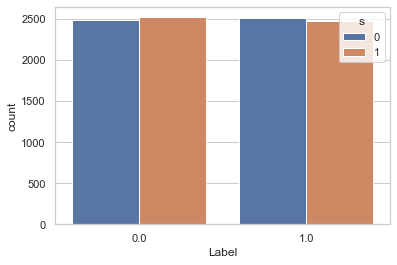

In [3]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.savefig('imgs/synt_unb.pdf')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [4]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Bias metrics

Here we train and test a _Logistic Regression_ classifier:

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7638
Statistical parity: 0.0173
Disparate impact: 1.0349
Average odds: 0.0134
Equal opportunity: 0.0178
Theil index: 0.1470


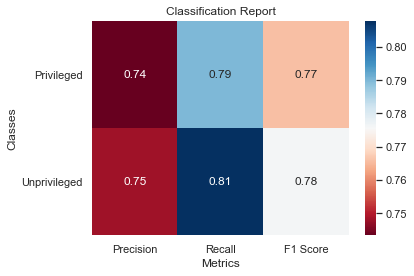

In [5]:
bin_data = BinaryLabelDataset(df=data, protected_attribute_names=['s'], label_names=['10'])

class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [6]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7633
Statistical parity: 0.0085
Disparate impact: 1.0170
Average odds: 0.0042
Equal opportunity: 0.0091
Theil index: 0.1475


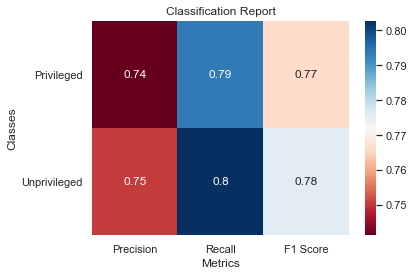

In [7]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group, debiaser=rw)

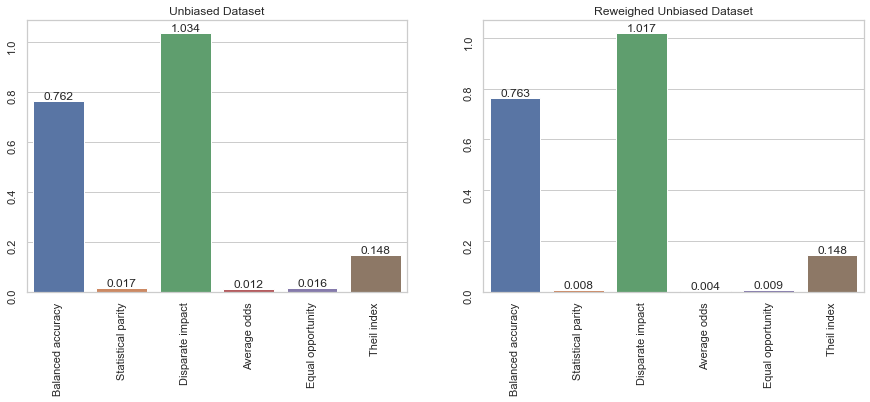

In [8]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [9]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [10]:
di = DisparateImpactRemover(sensitive_attribute='s')

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0161
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7667
Statistical parity: -0.0036
Disparate impact: 0.9958
Average odds: -0.0078
Equal opportunity: -0.0074
Theil index: 0.1357


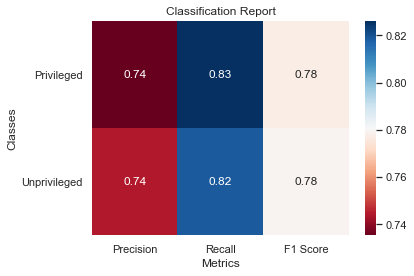

In [11]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=di)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


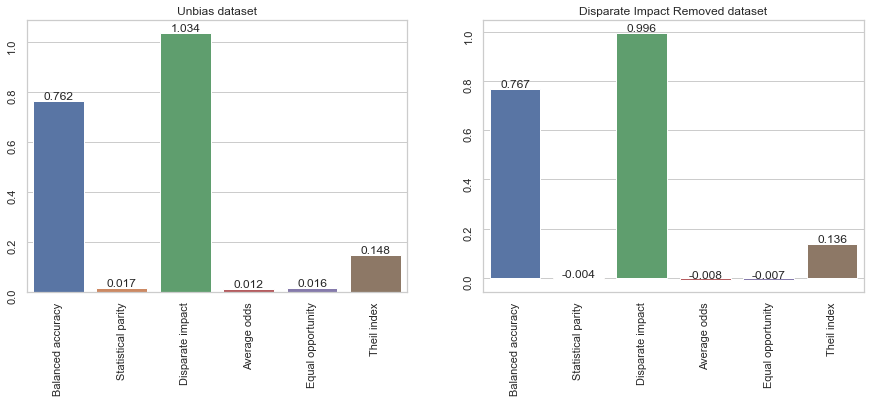

In [12]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

In [13]:
unb_sample_ds = bin_data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 1.0007
Statistical Parity: 0.0004




### Classification Metrics:

Balanced accuracy: 0.7615
Statistical parity: 0.0089
Disparate impact: 1.0173
Average odds: 0.0040
Equal opportunity: 0.0078
Theil index: 0.1489


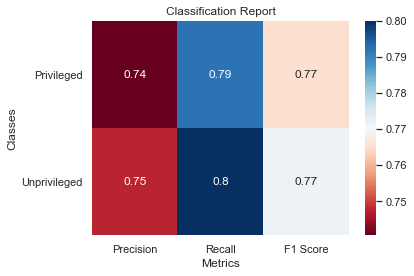

In [14]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


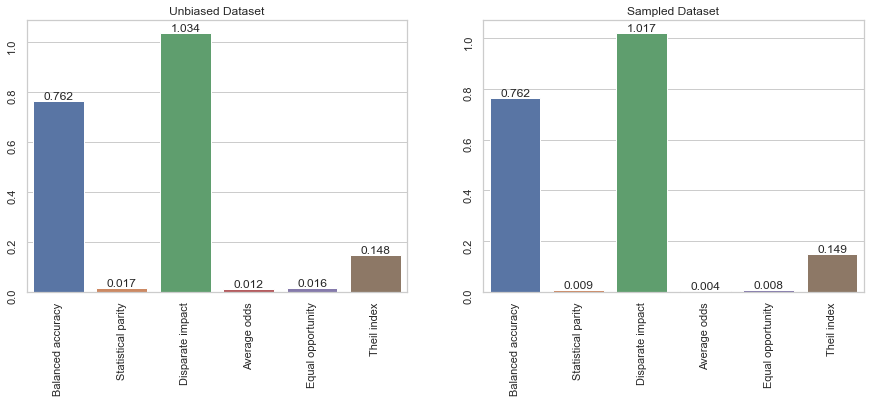

In [15]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [16]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0078,0.7667,0.9958,-0.0074,-0.0036,0.1357
Reweighed,0.0042,0.7633,1.0170,0.0091,0.0085,0.1475
Sampled Dataset,0.0040,0.7615,1.0173,0.0078,0.0089,0.1489
Unbias Data,0.0123,0.7624,1.0339,0.0165,0.0166,0.1480


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


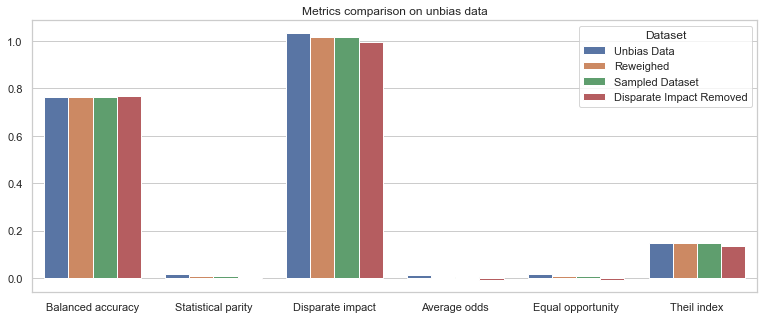

In [17]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.savefig('imgs/synthetic/syntesis_unb.pdf')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [4]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(len(data)/2)) , '10'] = 0.0

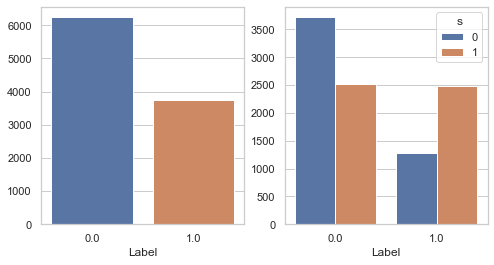

In [12]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(8,4))
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values, ax=ax1)
ax1.set_xlabel('Label')
sns.barplot(
    x='10', y='count', hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
    ax=ax2
)
ax2.set(xlabel= 'Label', ylabel='')
plt.savefig(os.path.join(path, 'unb_bias.pdf'))
plt.show()

Let's compute the dataset fairness metrics on this new dataset:

In [21]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7253
Statistical parity: -0.4001
Disparate impact: 0.3968
Average odds: -0.3565
Equal opportunity: -0.5190
Theil index: 0.1504


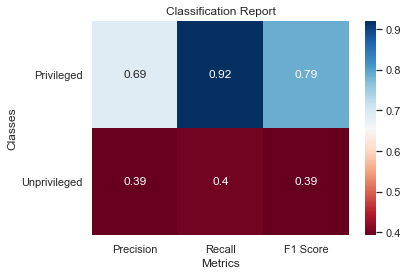

In [22]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [23]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7135
Statistical parity: -0.0676
Disparate impact: 0.8742
Average odds: 0.0099
Equal opportunity: -0.0877
Theil index: 0.1438


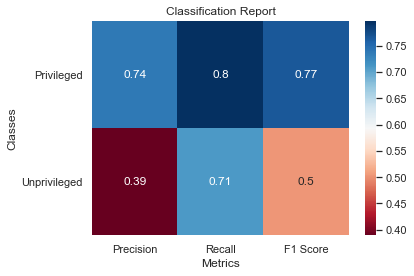

In [24]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


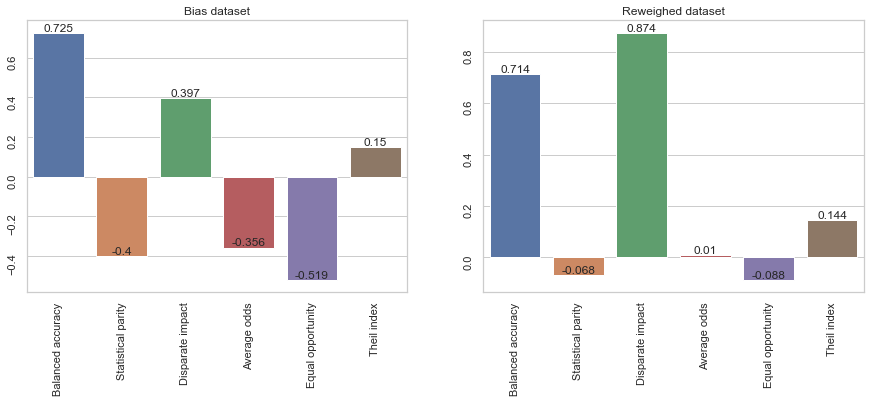

In [25]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [26]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


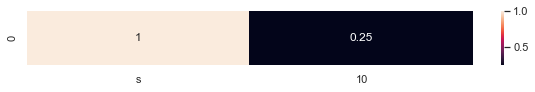

In [27]:
plot_correlation(dir_data, 's')
plt.show()

In [28]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_data = dr.fit_transform(dir_data)

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7069
Statistical parity: -0.0028
Disparate impact: 0.9969
Average odds: 0.0795
Equal opportunity: -0.0030
Theil index: 0.1391


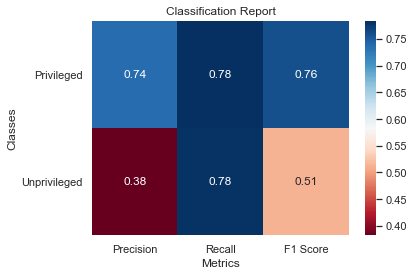

In [29]:
dir_class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


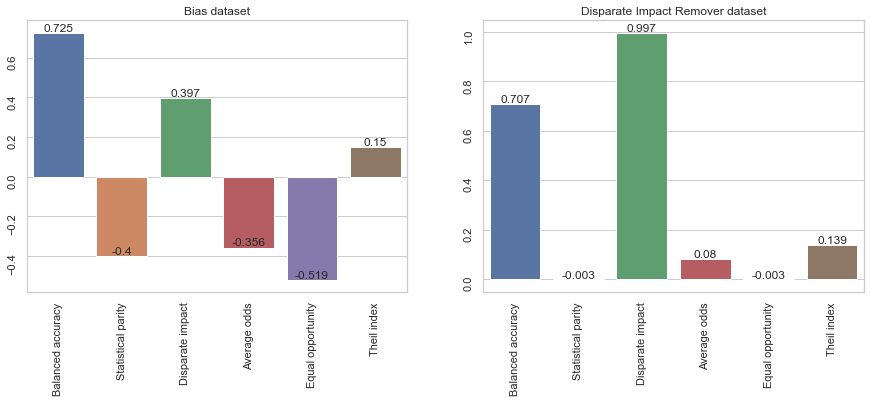

In [30]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

In [31]:
sampled_bias_data = bias_data_bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9882
Statistical Parity: -0.0044




### Classification Metrics:

Balanced accuracy: 0.7132
Statistical parity: -0.0733
Disparate impact: 0.8659
Average odds: 0.0025
Equal opportunity: -0.0969
Theil index: 0.1438


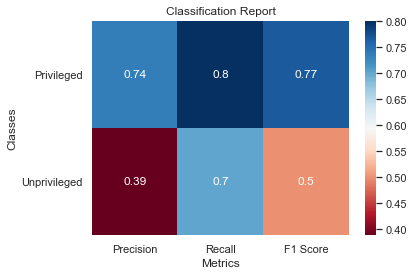

In [32]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sampled_bias_data, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


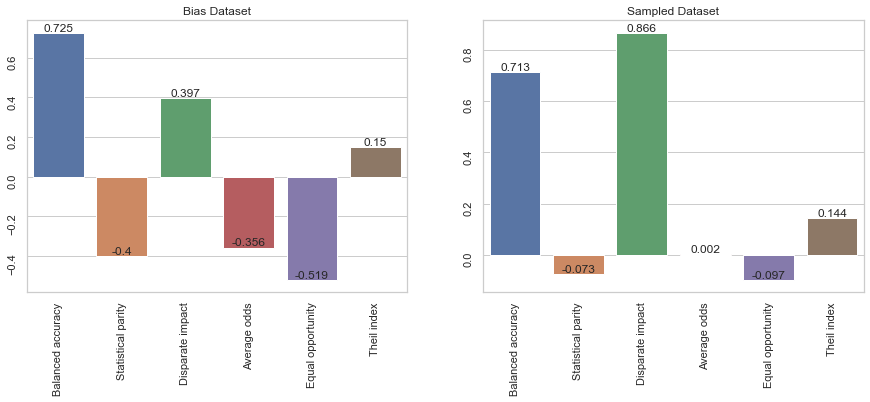

In [33]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [34]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3565,0.7253,0.3968,-0.5190,-0.4001,0.1504
Disparate Impact Removed,0.0795,0.7069,0.9969,-0.0030,-0.0028,0.1391
Reweighed,0.0099,0.7135,0.8742,-0.0877,-0.0676,0.1438
Sampled Dataset,0.0025,0.7132,0.8659,-0.0969,-0.0733,0.1438


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


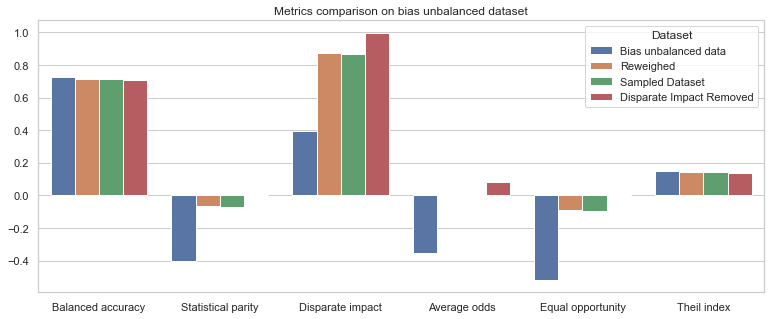

In [35]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.savefig(os.path.join(path,'unb_synt.pdf'))
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [13]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(len(data)/2)) & (bias_data['10']==0.0) , '10'] = 1.0

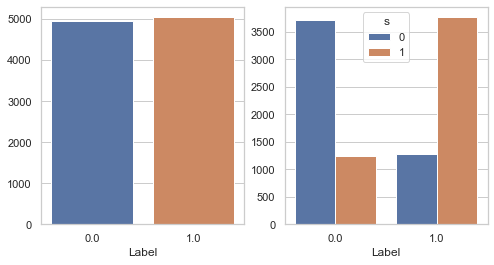

In [16]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(8,4))
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values, ax=ax1)
ax1.set_xlabel('Label')
sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(), ax=ax2
)
ax2.set(xlabel= 'Label',ylabel='')
plt.savefig(os.path.join(path,'bias_bal.pdf'))
plt.show()

In [39]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.7418
Statistical parity: -0.8858
Disparate impact: 0.0431
Average odds: -0.8562
Equal opportunity: -0.8886
Theil index: 0.1899


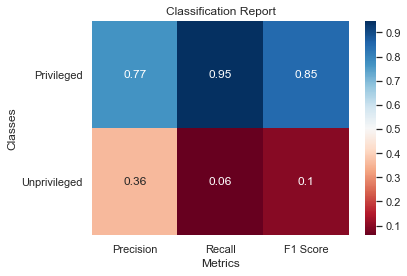

In [40]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)
plt.savefig('imgs/bias_class_report.pdf')

## Reweighing

In [41]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.6622
Statistical parity: -0.1385
Disparate impact: 0.7747
Average odds: 0.0311
Equal opportunity: 0.0252
Theil index: 0.2135


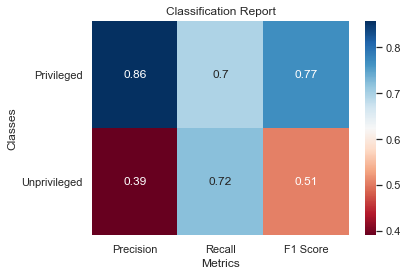

In [60]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group, debiaser=rw)
plt.savefig(os.path.join(path, 'class_report.pdf'))

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


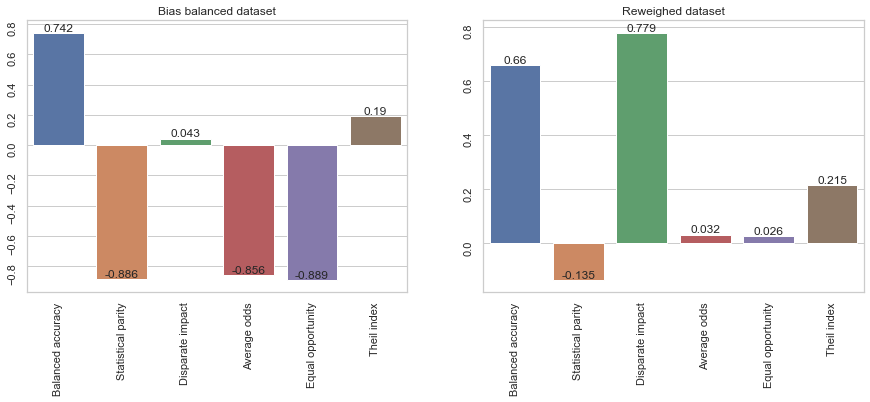

In [43]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

In [44]:
bias_sample_ds = bias_bal_bin.copy()
sampler = Sampler(round_level=3)

### Dataset Metrics:

Disparate Impact: 0.9992
Statistical Parity: -0.0004




### Classification Metrics:

Balanced accuracy: 0.6605
Statistical parity: -0.1360
Disparate impact: 0.7777
Average odds: 0.0320
Equal opportunity: 0.0268
Theil index: 0.2148


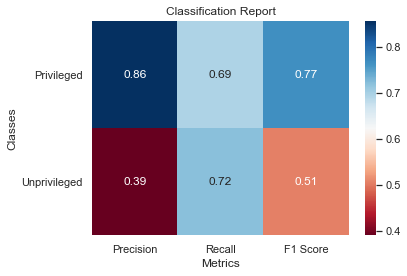

In [45]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


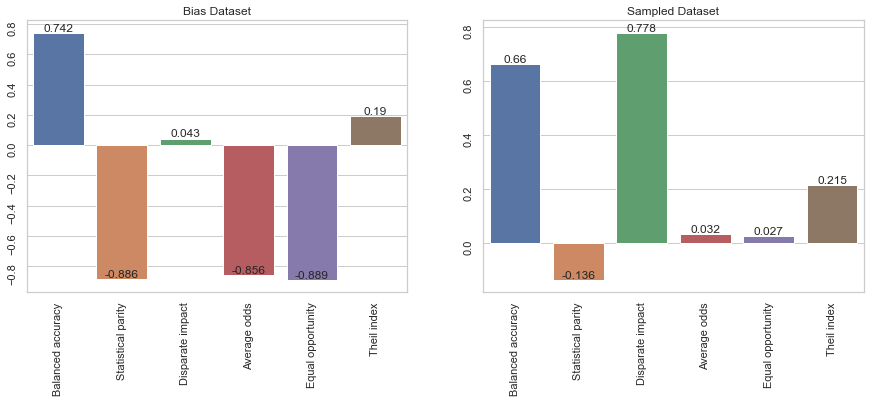

In [46]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [47]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


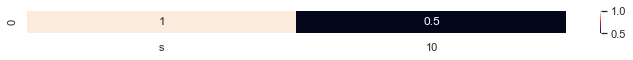

In [62]:
plot_correlation(dir_bal, 's')
plt.tight_layout()
plt.savefig(os.path.join(path, 'correlation.pdf'))
plt.show()

In [49]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_bal = dr.fit_transform(dir_bal)

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.6311
Statistical parity: -0.0005
Disparate impact: 1.0006
Average odds: 0.1722
Equal opportunity: 0.1804
Theil index: 0.2164


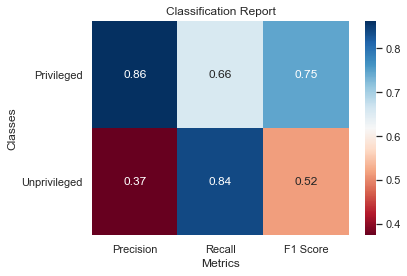

In [50]:
dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


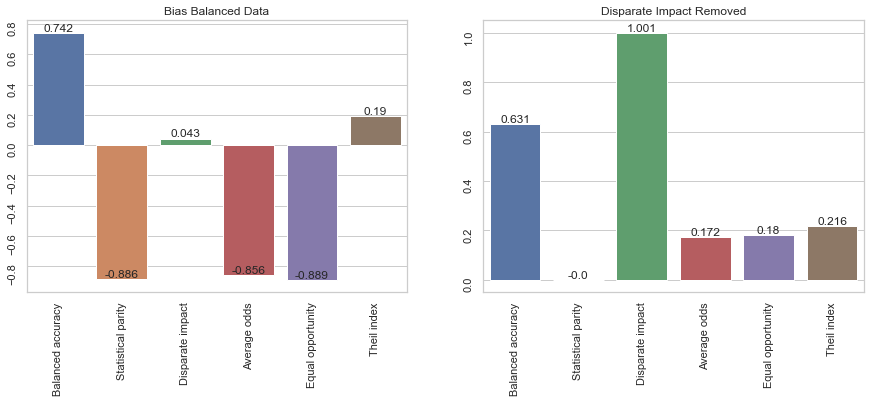

In [51]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [52]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8562,0.7418,0.0431,-0.8886,-0.8858,0.1899
Disparate Impact Removed,0.1722,0.6311,1.0006,0.1804,-0.0005,0.2164
Reweighed,0.0325,0.6603,0.7789,0.0264,-0.1348,0.2152
Sampled Dataset,0.0320,0.6605,0.7777,0.0268,-0.1360,0.2148


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


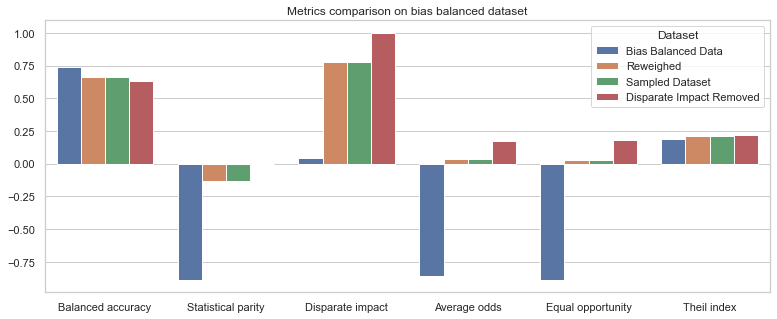

In [53]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


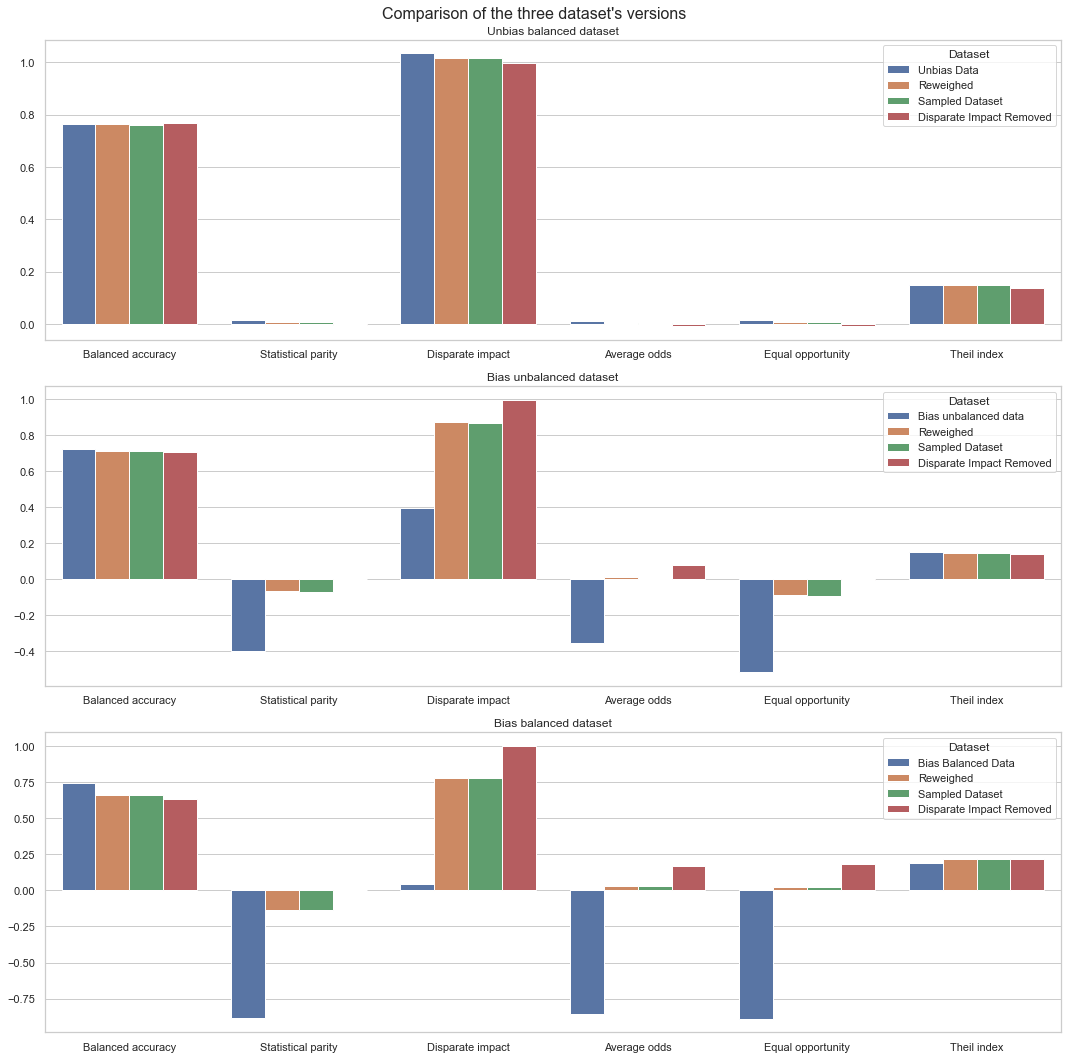

In [55]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(path,'metrics_comparison.pdf'))
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [63]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
#un_rw_dir = rw.fit_transform(un_rw_dir)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7630
Statistical parity: -0.0047
Disparate impact: 0.9931
Average odds: -0.0095
Equal opportunity: -0.0102
Theil index: 0.1481


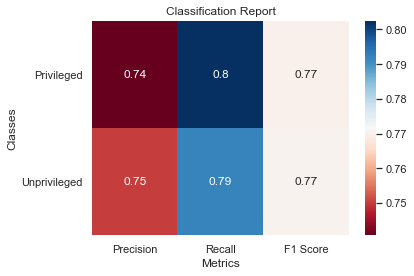

In [64]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=rw)

### Comparison

In [65]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'Sampling': unb_sample_metrics,
    'RW + DIR': unb_rw_dir_score
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0078,0.7667,0.9958,-0.0074,-0.0036,0.1357
RW + DIR,-0.0095,0.7630,0.9931,-0.0102,-0.0047,0.1481
Reweighed,0.0042,0.7633,1.0170,0.0091,0.0085,0.1475
Sampling,0.0040,0.7615,1.0173,0.0078,0.0089,0.1489
Unbias Data,0.0123,0.7624,1.0339,0.0165,0.0166,0.1480


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


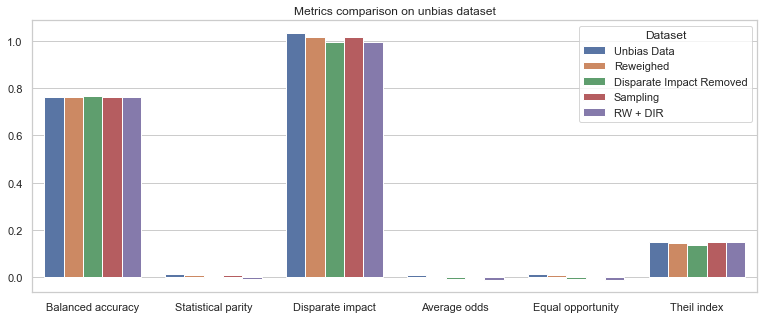

In [66]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.savefig(os.path.join(path, 'rw_dir_unb.pdf'))
plt.show()

## Test with unbalance bias data

In [67]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
#unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7064
Statistical parity: -0.0030
Disparate impact: 0.9959
Average odds: 0.0802
Equal opportunity: -0.0005
Theil index: 0.1478


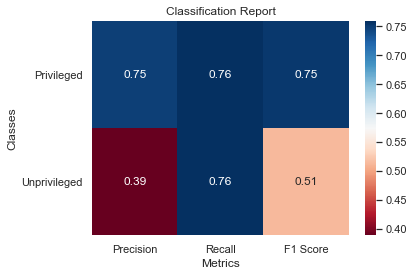

In [68]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=rw)

In [69]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'Sampling': sample_bias_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3565,0.7253,0.3968,-0.5190,-0.4001,0.1504
Disparate Impact Removed,0.0795,0.7069,0.9969,-0.0030,-0.0028,0.1391
RW + DIR,0.0802,0.7064,0.9959,-0.0005,-0.0030,0.1478
Reweighed,0.0099,0.7135,0.8742,-0.0877,-0.0676,0.1438
Sampling,0.0025,0.7132,0.8659,-0.0969,-0.0733,0.1438


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


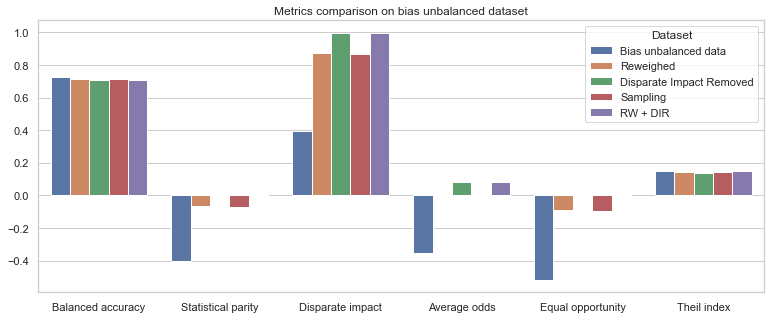

In [70]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.savefig(os.path.join(path, 'rw_dir_syn.pdf'))
plt.show()

## Test with balanced bias data

In [71]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
#dir_rw_data = rw.fit_transform(dir_rw_data)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6323
Statistical parity: -0.0036
Disparate impact: 0.9953
Average odds: 0.1684
Equal opportunity: 0.1733
Theil index: 0.2329


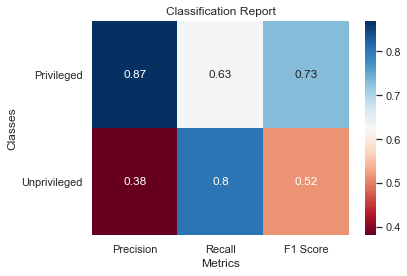

In [72]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=rw)

In [73]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'Sampling': sampling_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8562,0.7418,0.0431,-0.8886,-0.8858,0.1899
Disparate Impact Removed,0.1722,0.6311,1.0006,0.1804,-0.0005,0.2164
RW + DIR,0.1684,0.6323,0.9953,0.1733,-0.0036,0.2329
Reweighed,0.0311,0.6622,0.7747,0.0252,-0.1385,0.2135
Sampling,0.0320,0.6605,0.7777,0.0268,-0.1360,0.2148


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


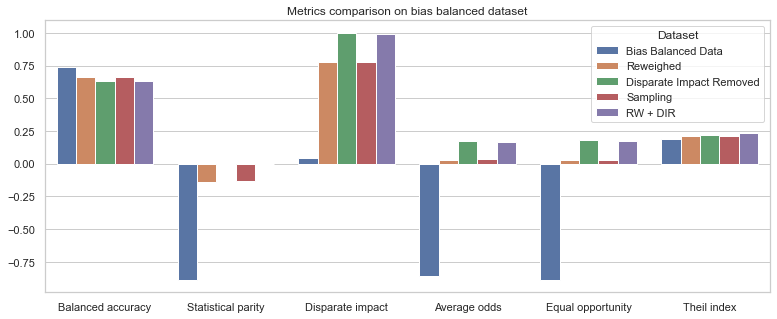

In [74]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.savefig(os.path.join(path, 'rw_dir_bias_bal.pdf'))
plt.show()